In [1]:
# pip install opencv-python==4.6.0.66 matplotlib==3.6.2 imageio==2.23.0 gdown==4.6.0 tensorflow==2.10.1


Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 3.6.0 Requires-Python >=3.8; 3.6.0rc1 Requires-Python >=3.8; 3.6.0rc2 Requires-Python >=3.8; 3.6.1 Requires-Python >=3.8; 3.6.2 Requires-Python >=3.8; 3.6.3 Requires-Python >=3.8; 3.7.0 Requires-Python >=3.8; 3.7.0rc1 Requires-Python >=3.8; 3.7.1 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement matplotlib==3.6.2 (from versions: 0.86, 0.86.1, 0.86.2, 0.91.0, 0.91.1, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.3.0, 1.3.1, 1.4.0, 1.4.1rc1, 1.4.1, 1.4.2, 1.4.3, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 2.0.0b1, 2.0.0b2, 2.0.0b3, 2.0.0b4, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.1.0rc1, 2.1.0, 2.1.1, 2.1.2, 2.2.0rc1, 2.2.0, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 3.0.0rc2, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.1.0rc1, 3.1.0rc2, 3.1.0, 3.1.1, 3.1.2, 3.1.3, 3.2.0rc1, 3.2.0rc3, 3.2.0, 3.2.1, 3.2.2, 3.3.0rc1, 3.3.0, 3.3.1, 3.3.2, 3.3.3, 3.3.4, 3.4.0rc1, 3.4.0rc2, 3.4.0rc3, 3.4.0, 3.4.1, 3.4.2, 3.4.3, 3.5.0b1, 3.5.0rc1, 

In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [4]:
import gdown

In [6]:
!pip install gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7dbdd539-efcf-4e3f-acb7-d5b244e19151
To: E:\DIP_PROJECT\Lip_Reading\data.zip
  1%|▉                                                                              | 5.24M/423M [00:09<14:26, 483kB/s]

In [6]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std
#  performs frame-wise normalization on the video frames, making use of TensorFlow functions to calculate the mean
# and standard deviation and then applying the normalization formula to each frame

NameError: name 'file_name' is not defined

# PREPROCEESING

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
char_to_num(['a','j'])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 1, 10], dtype=int64)>

In [9]:
num_to_char([14,  9,  3, 11])


<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [12]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'.\\data\\s1\\bbal6n.mpg'

In [14]:

tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [15]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.19734782],
          [ 0.07893913]],
 
         [[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.07893913],
          [ 0.03946957]],
 
         [[ 1.4209043 ],
          [ 1.4209043 ],
          [ 1.3814348 ],
          ...,
          [ 0.07893913],
          [ 0.07893913],
          [ 0.07893913]],
 
         ...,
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.94633   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.90686   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          

In [16]:

frames, alignments = load_data(tf.convert_to_tensor(test_path))

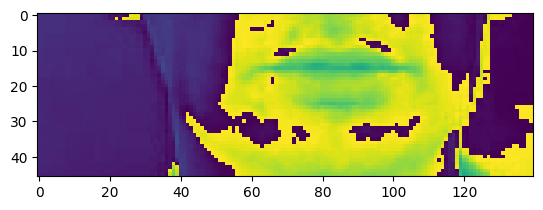

In [17]:
plt.imshow(frames[50])

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [19]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [14]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# CREATING DATA PIPELINE

In [12]:
from matplotlib import pyplot as plt


In [15]:

data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
# we are making sure that all tokens are of equal size that is 40 and is padded with zero
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [26]:
len(test)

50

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)


2

In [21]:
sample = data.as_numpy_iterator()

In [22]:
val = sample.next(); val[0]

array([[[[[1.5293257 ],
          [1.4528594 ],
          [1.2999269 ],
          ...,
          [0.3440983 ],
          [0.3440983 ],
          [0.3440983 ]],

         [[1.5293257 ],
          [1.4146264 ],
          [1.1469944 ],
          ...,
          [0.3440983 ],
          [0.3440983 ],
          [0.3440983 ]],

         [[1.5675589 ],
          [1.5675589 ],
          [1.4910926 ],
          ...,
          [0.38233143],
          [0.3440983 ],
          [0.3440983 ]],

         ...,

         [[1.070528  ],
          [1.070528  ],
          [1.070528  ],
          ...,
          [0.07646628],
          [0.07646628],
          [0.07646628]],

         [[1.070528  ],
          [1.070528  ],
          [1.070528  ],
          ...,
          [0.07646628],
          [0.07646628],
          [0.07646628]],

         [[1.070528  ],
          [1.070528  ],
          [1.070528  ],
          ...,
          [0.07646628],
          [0.07646628],
          [0.03823314]]],


        [[[1.4910

In [31]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.135005950927734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

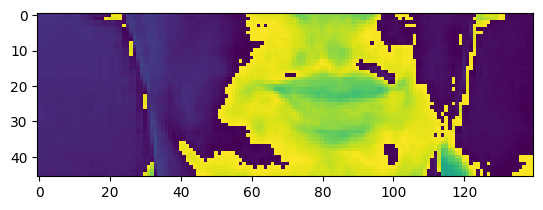

In [35]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][45])
# each video has 74 frames

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in d four please'>

In [37]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])


<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p seven soon'>

# Designing the Deep Neural Network


In [16]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [17]:

data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [18]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [48]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [23]:
yhat = model.predict(val[0])


1/1 [==============================] - 14s 14s/step


In [50]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'9999cccccccccccccccc??????????cccc????????????????????????????????cccccccc?'>

In [51]:
model.input_shape

(None, 75, 46, 140, 1)

In [52]:
model.output_shape

(None, 75, 41)

# Setting up Training options

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:

checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
# model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# Make a  Prediction

In [27]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=d1ad8d93-d471-48a9-8648-bfc6be47bf0f
To: E:\DIP_PROJECT\Lip_Reading\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:06<00:00, 15.5MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [24]:
model.load_weights('models/checkpoint')

In [25]:

test_data = test.as_numpy_iterator()

In [26]:
sample = test_data.next()

In [27]:
yhat = model.predict(sample[0])

1/1 [==============================] - 10s 10s/step


In [28]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at g one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l one soon'>]

In [29]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [30]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at g one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with one soon'>]

# Test on the video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]